# Set up the environment

In [2]:
#Arguments/Parameters
working_dir = '/home/jupyter/notebooks/Ancestry' #home directory for this workspace
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET') #the workspace bucket that we will upload the output to

In [3]:
#Load packages
library(tidyverse)
library(reshape2)
library(pwr)


#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




# Calculate the median SD of Chronos scores

In [4]:
#Load the chronos data into R
#Load the chronos scores and format it
paste(working_dir, "/gwas", sep = "") %>% setwd() #set the working directory
chronos.scores <- read.table('CRISPR_gene_effect.csv', sep = ",", header = F)
colnames(chronos.scores) = sub(" .*", "", chronos.scores[1,]) #Remove all of the junk after the gene name
chronos.scores <- chronos.scores[-1,] #Remove the old 'col.names' row.
colnames(chronos.scores)[1] <- "IID" #Convert the column name for the first column to IID, as per the formatting requirements for the .pheno file
chronos.scores[chronos.scores == ""] <- 0 #Replace the missing values with 0. Clearly not the best solution, but it is A solution. And these are rare cases, so it shouldn't affect it too much.   



In [5]:
#Calculate the median SD for all genes in DepMap. 
#This SD will be used in the power calculation
chronos.median = chronos.scores %>%
select(-IID) %>%
apply(2, as.numeric) %>%
apply(2, sd) %>%
median()


# Calculate the number of cell lines for each ancestry group

In [6]:
#Calculate the number of samples for each ancestry group
paste(working_dir, "/admixture", sep = "") %>% setwd()
lines.per.ancestry <- read.table('ancestry.by.cancer.type.txt', sep = "", header = T) %>%
group_by(popmax) %>%
summarise(sum(n)) %>%
rename("sum" = 2)

head(lines.per.ancestry)
total.lines = lines.per.ancestry$sum %>% sum
total.lines

popmax,sum
<chr>,<int>
Admixed,67
African (AFR),23
American (AMR),1
East Asian (EAS),201
European (EUR),324
South Asian (SAS),3


[1] 619

# Now perform the power calculation

In [7]:
#Calculate the FDR corrected p-value for the power calculation
fdr.cutoff = 0.05/(ncol(chronos.scores) -1)


#Loop through all of the differentials and calculate the power
differential.seq = seq(from = 0.01, to = 1, by = 0.01) #define the differential values
sd = 0.25 #define the standard deviation. I picked this sd by looking at the distrubtion of all of the sd values for each chronos gene.


#Define the vectors
afr.power = NULL
amr.power = NULL
eas.power = NULL
eur.power = NULL
sas.power = NULL
adm.power = NULL



    for(dif in differential.seq){
        cohen.d = dif/sd
        
        #Calculate the power
        afr.val = pwr.t2n.test(n1 = 23, n2 = 619-23, d = cohen.d, sig.level = fdr.cutoff, alternative = "two.sided")$power #AFR
        amr.val = pwr.t2n.test(n1 = 2, n2 = 619-2, d = cohen.d, sig.level = fdr.cutoff, alternative = "two.sided")$power #AMR
        eas.val = pwr.t2n.test(n1 = 201, n2 = 619-201, d = cohen.d, sig.level = fdr.cutoff, alternative = "two.sided")$power #EAS
        eur.val = pwr.t2n.test(n1 = 324, n2 = 619-324, d = cohen.d, sig.level = fdr.cutoff, alternative = "two.sided")$power #EUR
        sas.val = pwr.t2n.test(n1 = 3, n2 = 619-3, d = cohen.d, sig.level = fdr.cutoff, alternative = "two.sided")$power #SAS
        adm.val = pwr.t2n.test(n1 = 67, n2 = 619-67, d = cohen.d, sig.level = fdr.cutoff, alternative = "two.sided")$power #Admixed

        #Bind it into the main vector(s)
        afr.power = c(afr.power, afr.val)
        amr.power = c(amr.power, amr.val)
        eas.power = c(eas.power, eas.val)
        eur.power = c(eur.power, eur.val)
        sas.power = c(sas.power, sas.val)
        adm.power = c(adm.power, adm.val)
        
        
    }


# Plot the data from the power calculation

Saving 10 x 6.67 in image



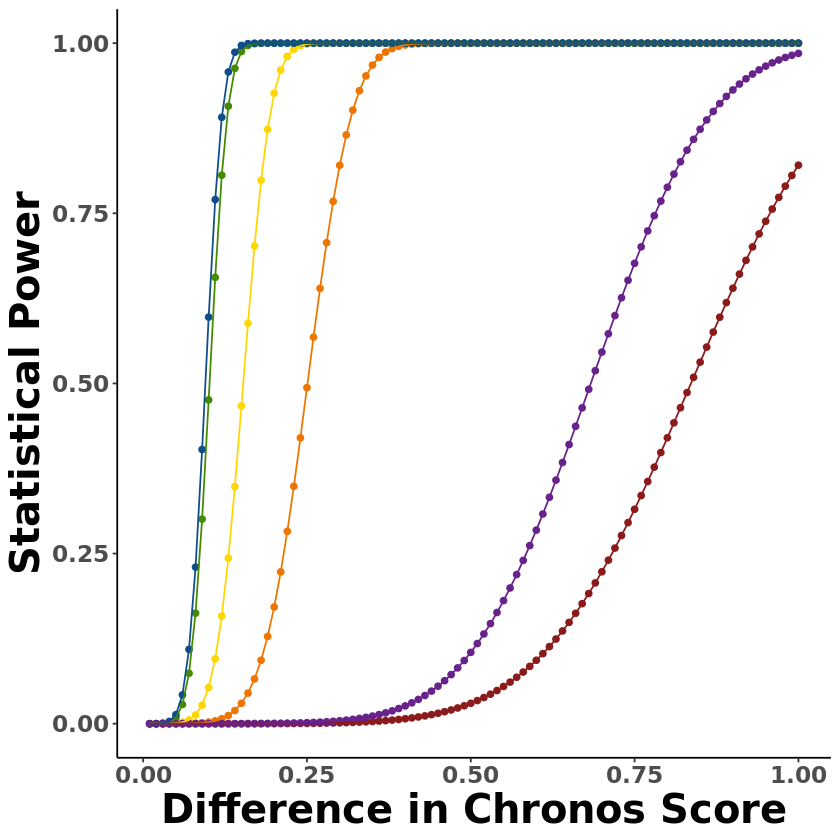

In [21]:
#First, bind everything into a single data frame and generate the plot
cbind(differential.seq, adm.power, afr.power, amr.power, eas.power, eur.power, sas.power) %>%
data.frame() %>%
rename("Effect_Size" = 1, "Admixed" = 2, "African (AFR)" = 3, "American (AMR)" = 4, "East Asian (EAS)" = 5, "European (EUR)" = 6, "South Asian (SAS)" = 7) %>%
melt(id = "Effect_Size") %>%
rename("Ancestry" = variable) %>%
ggplot() +
geom_point(aes(x = Effect_Size, y = value, color = Ancestry)) +
geom_line(aes(x = Effect_Size, y = value, color = Ancestry)) +

scale_color_manual(values = c("gold", "darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +
theme_bw() +


theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")
) +


theme(
axis.text=element_text(size=12),
axis.title=element_text(size=14, face="bold")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +


theme(
legend.title.align=0.5
) +

theme(
strip.text = element_text(size = 8, face = "bold"),
strip.background = element_blank()
) +

xlab("Difference in Chronos Score") +
ylab ("Statistical Power") +

theme(
axis.title=element_text(size = 24,face = "bold")
) +

theme(
legend.position = "none"
)


#Save the plot
paste({working_dir}, "/figures", sep = "") %>% setwd()
ggsave("ancestry_power_calculation.png", width = 10, dpi = 700)

#Export it to the google bucket
system(glue::glue("
cd {working_dir}/figures
gsutil cp ancestry_power_calculation.png gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))